In [1]:
import os
os.environ['DDE_BACKEND'] = 'tensorflow'
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import deepxde as dde
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Problem constants
N = 1e7
L = 6e-2  # m
R = 4e-3  # m
t_last = 0.1  # s
D_L = 3.8e-11  # m^2/s
V_H = 2e-6  # m^3/mole
RT = 8.314 * 298  # J/mole
Coe = (D_L * V_H) / RT

# Define Geometry and Sampling
square = dde.geometry.Rectangle([0, 0], [L, L])
circle = dde.geometry.Disk([0, 0], R)
geom = dde.geometry.csg.CSGDifference(square, circle)
timedomain = dde.geometry.TimeDomain(0, t_last)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Load Data
df = pd.read_excel('Hydrostatic Data with Nodes.xlsx')
n = 1000
sampled_data = df.sample(n=n)
train_data, test_data = train_test_split(sampled_data, test_size=0.4, random_state=42)
x_train = np.array(train_data['x'].values).reshape(-1, 1)
y_train = np.array(train_data['y'].values).reshape(-1, 1)
sigma_train = np.array(train_data['sigma'].values).reshape(-1, 1)
x_test = np.array(test_data['x'].values).reshape(-1, 1)
y_test = np.array(test_data['y'].values).reshape(-1, 1)
sigma_test = np.array(test_data['sigma'].values).reshape(-1, 1)
data_x = np.column_stack((x_train, y_train))
test_x = np.column_stack((x_test, y_test))

# Build net_sigma
def build_net_sigma():
    inputs_sigma = tf.keras.Input(shape=(2,))  # x, y
    x = inputs_sigma
    for units in [60] * 10:
        x = tf.keras.layers.Dense(units, activation="relu", kernel_initializer="he_normal")(x)
    outputs_sigma = tf.keras.layers.Dense(1)(x)
    model_sigma = tf.keras.Model(inputs=inputs_sigma, outputs=outputs_sigma)
    return model_sigma

# Load pre-trained net_sigma or define from scratch
net_sigma = build_net_sigma()
# If you have pre-trained weights, load them here:
# net_sigma.load_weights('path_to_net_sigma_weights.h5')

# Define a combined network that includes both net_sigma and net_C_L
class CombinedNet(dde.nn.NeuralNetwork):
    def __init__(self):
        super(CombinedNet, self).__init__()
        self.net_sigma = build_net_sigma()
        self.layers_C_L = []
        for units in [100] * 5:
            self.layers_C_L.append(tf.keras.layers.Dense(units, activation="tanh", kernel_initializer="Orthogonal"))
        self.output_C_L = tf.keras.layers.Dense(1, name='C_L')

    def call(self, inputs):
        # inputs: [x, y, t]
        x = inputs
        x_y = x[:, :2]  # Extract x and y for net_sigma
        sigma = self.net_sigma(x_y) / N  # Get sigma from net_sigma

        # Build net_C_L
        x_C_L = x
        for layer in self.layers_C_L:
            x_C_L = layer(x_C_L)
        C_L = self.output_C_L(x_C_L)

        # Concatenate outputs
        outputs = tf.concat([C_L, sigma], axis=1)
        return outputs

# Define PDE function
def pde_C_L(x, y):
    C_L = y[:, 0:1]
    Sig = y[:, 1:2]
    dC_dt = dde.grad.jacobian(y, x, i=0, j=2)
    CL_x = dde.grad.jacobian(y, x, i=0, j=0)
    CL_y = dde.grad.jacobian(y, x, i=0, j=1)
    CL_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    CL_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)

    h_sigma_x = dde.grad.jacobian(y, x, i=1, j=0)
    h_sigma_y = dde.grad.jacobian(y, x, i=1, j=1)
    h_sigma_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    h_sigma_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    eq1 = (
        dC_dt / N
        - D_L * (CL_xx + CL_yy)
        + Coe * N * (CL_x * h_sigma_x + CL_y * h_sigma_y + C_L * (h_sigma_xx + h_sigma_yy))
    )
    eq3 = Sig - y[:, 1:2]  # Ensure sigma is consistent with net_sigma
    return [eq1, eq3]

# Initial condition
ic = dde.icbc.IC(geomtime, lambda x: 20.0, lambda x, on_initial: on_initial, component=0)

# Observed data for sigma (assumed to be available)
data_observe = pd.read_excel('Hydrostatic Data with Nodes.xlsx')
data_observe_sample = data_observe.sample(frac=1, random_state=7)
x_data = data_observe_sample['x'].values
y_data = data_observe_sample['y'].values
sigma_data = data_observe_sample['sigma'].values
x_sigma_data = x_data.reshape(-1, 1)
y_sigma_data = y_data.reshape(-1, 1)
t_sigma_data = np.zeros_like(x_sigma_data)  # Assuming observations at t=0
X_sigma = np.hstack((x_sigma_data, y_sigma_data, t_sigma_data))
observe_sigma = dde.icbc.PointSetBC(
    points=X_sigma, values=sigma_data.reshape(-1, 1), component=1
)

# Dataset and model setup
data = dde.data.TimePDE(
    geomtime,
    pde_C_L,
    [ic, observe_sigma],  # Include observed sigma data
    num_domain=500,
    num_boundary=500,
    num_initial=500,
    num_test=500,
)

# Initialize and train the combined model
net = CombinedNet()
model = dde.Model(data, net)
model.compile("adam", lr=1e-5)
losshistory, train_state = model.train(epochs=400000, display_every=1000)

# Save the training history and plot results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


AttributeError: module 'deepxde.nn.tensorflow' has no attribute 'NeuralNetwork'

Compiling model...
'compile' took 0.001279 s

Training model...

0         [5.24e-11, 2.80e-02, 4.01e+02, 2.59e+01][5.90e-11, 2.80e-02, 4.01e+02, 2.59e+01][]  
1000      [9.27e-04, 1.14e-03, 1.38e+02, 9.49e+00][8.94e-04, 7.99e-04, 1.38e+02, 9.49e+00][]  
2000      [3.30e-04, 1.25e-05, 4.39e+01, 6.92e+00][3.06e-04, 7.16e-06, 4.39e+01, 6.92e+00][]  
3000      [7.27e-05, 5.82e-06, 2.66e+01, 6.89e+00][6.66e-05, 3.81e-06, 2.66e+01, 6.89e+00][]  
4000      [2.13e-05, 2.04e-06, 1.72e+01, 6.89e+00][1.94e-05, 1.45e-06, 1.72e+01, 6.89e+00][]  
5000      [7.63e-06, 7.45e-07, 1.07e+01, 6.89e+00][6.94e-06, 5.49e-07, 1.07e+01, 6.89e+00][]  
6000      [3.18e-06, 2.99e-07, 6.08e+00, 6.89e+00][2.89e-06, 2.25e-07, 6.08e+00, 6.89e+00][]  
7000      [1.50e-06, 1.33e-07, 3.01e+00, 6.89e+00][1.37e-06, 1.01e-07, 3.01e+00, 6.89e+00][]  
8000      [8.13e-07, 6.71e-08, 1.20e+00, 6.89e+00][7.38e-07, 5.14e-08, 1.20e+00, 6.89e+00][]  
9000      [5.10e-07, 3.94e-08, 3.28e-01, 6.89e+00][4.63e-07, 3.03e-08, 3.28e-01,

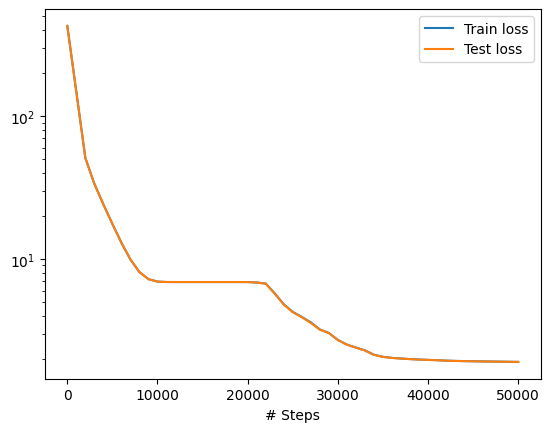

In [11]:
import os
os.environ['DDE_BACKEND'] = 'tensorflow'
import pandas as pd
import numpy as np
import tensorflow as tf
import deepxde as dde
import matplotlib.pyplot as plt

# Problem constants
N = 1e7
L = 6e-2  # m
R = 4e-3  # m
t_last = 0.1  # s
D_L = 3.8e-11*N  # m^2/s
V_H = 2e-6     # m^3/mole
RT = 8.314 * 298  # J/mole
Coe = (D_L * V_H) / RT

# Define Geometry and Time Domain
square = dde.geometry.Rectangle([0, 0], [L, L])
circle = dde.geometry.Disk([0, 0], R)
geom = dde.geometry.csg.CSGDifference(square, circle)
timedomain = dde.geometry.TimeDomain(0, t_last)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial condition for C_L
def initial_condition(x):
    return 20.0  # Initial value of C_L

ic = dde.icbc.IC(geomtime, initial_condition, lambda x, on_initial: on_initial, component=0)

# Define the PDE system
def pde_system(x, y):
    C_L = y[:, 0:1]
    sigma = y[:, 1:2]
    dC_dt = dde.grad.jacobian(y, x, i=0, j=2)
    CL_x = dde.grad.jacobian(y, x, i=0, j=0)
    CL_y = dde.grad.jacobian(y, x, i=0, j=1)
    CL_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    CL_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    sigma_t=dde.grad.jacobian(y,x,i=1,j=2)
    sigma_x = dde.grad.jacobian(y, x, i=1, j=0)
    sigma_y = dde.grad.jacobian(y, x, i=1, j=1)
    sigma_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    sigma_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    eq1 = (dC_dt/N- D_L* (CL_xx + CL_yy)+ Coe * N * (CL_x * sigma_x+ CL_y * sigma_y+ C_L * (sigma_xx + sigma_yy)))
    eq2=sigma_t
    return [eq1,eq2]

# Observed data (if available)
# Load your observed data for sigma (or any other variable)
df_observed = pd.read_excel('Hydrostatic Data with Nodes.xlsx')
x_observed = df_observed['x'].values.reshape(-1, 1)
y_observed = df_observed['y'].values.reshape(-1, 1)
t_observed = np.zeros_like(x_observed)  # Assuming observations at t=0
sigma_observed = df_observed['sigma'].values.reshape(-1, 1)/N
X_observed = np.hstack((x_observed, y_observed, t_observed))

# Define the boundary condition for sigma (if needed)
def sigma_observed_func(x):
    # Interpolate or provide sigma values at the observed points
    return sigma_observed

# Create PointSet for observed data
observe_sigma = dde.icbc.PointSetBC(X_observed, sigma_observed, component=1)

# Define the data
data = dde.data.TimePDE(
    geomtime,
    pde_system,
    [ic, observe_sigma],  # Include observed data
    num_domain=2000,
    num_boundary=1000,
    num_initial=1000,
    num_test=1000,
)

# Define the neural network
layer_size = [3] + [100] * 5 + [2]  # 3 inputs (x, y, t) and 2 outputs (C_L, sigma)
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# Compile the model
model = dde.Model(data, net)
model.compile(
    "adam",
    lr=1e-5  # Adjust loss weights as needed
)

# Train the model
losshistory, train_state = model.train(epochs=50000)

# Plot the loss history
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [ ]:
import os
os.environ['DDE_BACKEND'] = 'tensorflow'
import pandas as pd
import numpy as np
import tensorflow as tf
import deepxde as dde
import matplotlib.pyplot as plt

# Problem constants
N = 1e7
L = 6e-2  # m
R = 4e-3  # m
t_last = 0.1  # s
D_L = 3.8e-11*N  # m^2/s
V_H = 2e-6     # m^3/mole
RT = 8.314 * 298  # J/mole
Coe = (D_L * V_H) / RT

# Define Geometry and Time Domain
square = dde.geometry.Rectangle([0, 0], [L, L])
circle = dde.geometry.Disk([0, 0], R)
geom = dde.geometry.csg.CSGDifference(square, circle)
timedomain = dde.geometry.TimeDomain(0, t_last)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial condition for C_L
def initial_condition(x):
    return 20.0  # Initial value of C_L

ic = dde.icbc.IC(geomtime, initial_condition, lambda x, on_initial: on_initial, component=0)

# Define the PDE system
def pde_system(x, y):
    C_L = y[:, 0:1]
    sigma = y[:, 1:2]
    dC_dt = dde.grad.jacobian(y, x, i=0, j=2)
    CL_x = dde.grad.jacobian(y, x, i=0, j=0)
    CL_y = dde.grad.jacobian(y, x, i=0, j=1)
    CL_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    CL_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    sigma_t=dde.grad.jacobian(y,x,i=1,j=2)
    sigma_x = dde.grad.jacobian(y, x, i=1, j=0)
    sigma_y = dde.grad.jacobian(y, x, i=1, j=1)
    sigma_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    sigma_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    eq1 = (dC_dt/N- D_L* (CL_xx + CL_yy)+ Coe * N * (CL_x * sigma_x+ CL_y * sigma_y+ C_L * (sigma_xx + sigma_yy)))
    eq2=sigma_t
    return [eq1,eq2]

# Observed data (if available)
# Load your observed data for sigma (or any other variable)
df_observed = pd.read_excel('Hydrostatic Data with Nodes.xlsx')
x_observed = df_observed['x'].values.reshape(-1, 1)
y_observed = df_observed['y'].values.reshape(-1, 1)
t_observed = np.zeros_like(x_observed)  # Assuming observations at t=0
sigma_observed = df_observed['sigma'].values.reshape(-1, 1)/N
X_observed = np.hstack((x_observed, y_observed, t_observed))

# Define the boundary condition for sigma (if needed)
def sigma_observed_func(x):
    # Interpolate or provide sigma values at the observed points
    return sigma_observed

# Create PointSet for observed data
observe_sigma = dde.icbc.PointSetBC(X_observed, sigma_observed, component=1)

# Define the data
data = dde.data.TimePDE(
    geomtime,
    pde_system,
    [ic, observe_sigma],  # Include observed data
    num_domain=2000,
    num_boundary=1000,
    num_initial=1000,
    num_test=1000,
)

# Define the neural network
layer_size = [3] + [100] * 5 + [2]  # 3 inputs (x, y, t) and 2 outputs (C_L, sigma)
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# Compile the model
model = dde.Model(data, net)
model.compile(
    "adam",
    lr=1e-5  # Adjust loss weights as needed
)

# Train the model
losshistory, train_state = model.train(epochs=50000)

# Plot the loss history
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [20]:
import numpy as np
import deepxde as dde

# Exact solution for validation
def exact_solution(x):
    return np.exp(-x)

# Define the geometry (domain of the problem)
geom = dde.geometry.Interval(0, 1)

# Define the PDE residual function
def pde(x, y):
    dy_dx = dde.grad.jacobian(y, x)  # Compute du/dx
    integral = dde.grad.quad(y, x)   # Compute \int_{0}^{x} u(s) ds
    return dy_dx + integral          # Residual: du/dx + \int_{0}^{x} u(s) ds = 0

# Define the boundary condition u(0) = 1
def boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

bc = dde.DirichletBC(geom, lambda x: 1.0, boundary)

# Set up the data for the PDE problem
data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=40,
    num_boundary=1,
    solution=exact_solution,  # Optional: provides exact solution for monitoring
)

# Define the neural network (FNN with 3 hidden layers of 50 neurons each)
net = dde.maps.FNN([1] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Create the model by combining data and network
model = dde.Model(data, net)

# Compile and train the model
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=10000)

# Plot the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Compiling model...
'compile' took 0.003954 s

Training model...



AttributeError: in user code:

    File "C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\deepxde\model.py", line 230, in outputs_losses_train  *
        True, inputs, targets, auxiliary_vars, self.data.losses_train
    File "C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\deepxde\model.py", line 215, in outputs_losses  *
        losses = losses_fn(targets, outputs_, loss_fn, inputs, self, aux=aux)
    File "C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\deepxde\data\data.py", line 13, in losses_train  *
        return self.losses(targets, outputs, loss_fn, inputs, model, aux=aux)
    File "C:\Users\yesda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\deepxde\data\pde.py", line 149, in losses  *
        f = self.pde(inputs, outputs_pde)
    File "C:\Users\yesda\AppData\Local\Temp\ipykernel_16912\3998215234.py", line 14, in pde  *
        integral = dde.grad.quad(y, x)   # Compute \int_{0}^{x} u(s) ds

    AttributeError: module 'deepxde.gradients' has no attribute 'quad'
